In [2]:
import pprint
from itertools import chain
import functools
import itertools
import random

from fuzzywuzzy import fuzz
from pymongo import MongoClient
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import scipy
from cycler import cycler

from esc_identifier.distance import (
    # Frequence based distances
    ratio_distance,
    partial_ratio_distance,
    token_sort_distance,
    partial_token_sort_distance,
    token_set_distance,
    partial_token_set_distance,
    # Edit distances
    jaro_distance,
    jaro_winkler_distance,
    levenshtein,
    levenshtein_sort,
    damerau_levenshtein,
)
from esc_identifier.cluster import dbscan, get_clusters
# from esc_identifier.utils import prepare_string
from esc_identifier.utils.string import (
    normalize_affiliation, normalize_human_name)
from jupyter_utils import log_progress

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
MONGO_URI = 'mongodb://localhost:27017/'

mongo_client = MongoClient(MONGO_URI)
kdd_db = mongo_client.kdd2013
author_collection = kdd_db.author

In [4]:
def generate_test_data(dataset, size, sample_length, max_variations):
    X_test, y_test = [], []

    for _ in range(size):
        data_sample = random.sample(dataset, sample_length)
        clusters = [random.sample(item,
                                  random.randint(1,
                                                 min(len(item),
                                                     max_variations)
                                                )
                                 )
                    for item
                    in data_sample]

        y_true = list(itertools.chain.from_iterable([i] * len(cluster) for i, cluster in enumerate(clusters)))
        
        X_test.append(list(itertools.chain.from_iterable(clusters)))
        y_test.append(y_true)
    
    return X_test, y_test

In [5]:
author_cache = list(author_collection.find())
names_data = [author['names'] for author in author_cache]
affiliations_data = [author['affiliations'] for author in author_cache]

In [48]:
dataset = affiliations_data
test_data_size = 100
sample_size = 5
max_variations = 5
random_seed = 42

random.seed(random_seed)

X_test, y_test = generate_test_data(
    dataset=dataset,
    size=test_data_size,
    sample_length=sample_size,
    max_variations=max_variations)

In [49]:
import warnings
warnings.filterwarnings('ignore')

distance_functions = [
    (functools.partial(token_sort_distance, full_process=False),
     'Token sort ratio'),
    (functools.partial(token_set_distance, full_process=False),
     'Token set ratio'),
    (levenshtein, 'Levenshtein'),
#     (levenshtein_sort, 'Levenshtein sort'),
    (ratio_distance, 'Ratio'),
    (partial_ratio_distance, 'Partial ratio'),
#     (partial_token_sort_distance, 'Partial token sort ratio'),
#     (partial_token_set_distance, 'Partial token set ratio'),
    (jaro_distance, 'Jaro'),
    (jaro_winkler_distance, 'Jaro-Winkler'),
    (damerau_levenshtein, 'Damerau-Levenshtein'),
#     (most_freq_k_sdf_normalized, 'MostFreqKSDF')
]

# Other variants: min, np.median, scipy.stats.hmean
avg_f = np.mean

eps_range = np.linspace(0.01, 0.9, 50)
df = pd.DataFrame()

precision_recall_fbeta = {}

for (distance_function, distance_function_name) in distance_functions:
    global_precision, global_recall, global_fbeta_score = [], [], []

    for _, eps in log_progress(eps_range, name=distance_function_name):
        measurements = []
        for X, y_true in zip(X_test, y_test):
            clusters_pred = get_clusters(X, distance_function=distance_function, eps=eps)
            y_pred = []
            for i in range(len(y_true)):
                cluster_index = list(cluster_idx
                                     for cluster_idx, cluster
                                     in enumerate(clusters_pred)
                                     if i in cluster
                                    )[0]
                y_pred.append(cluster_index)
            precision, recall, fbeta_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            measurements.append((precision, recall, fbeta_score))

        p, r, f1 = list(zip(*measurements))
        global_precision.append(avg_f(p))
        global_recall.append(avg_f(r))
        global_fbeta_score.append(avg_f(f1))
    
    precision_recall_fbeta[distance_function_name] = (global_precision, global_recall, global_fbeta_score)

    best_eps, best_fbeta, best_precision, best_recall = \
        max(zip(eps_range,
                global_fbeta_score,
                global_precision,
                global_recall
               ),
            key=lambda x: x[1])

    df = df.append(
        pd.DataFrame({
            'eps': [best_eps],
            'precision': [best_precision],
            'recall': [best_recall],
            'f-beta': [best_fbeta],
        },
        columns=['eps', 'precision', 'recall', 'f-beta'],
        index=[distance_function_name])
    )
    
df.sort_values('f-beta', ascending=False)

,eps,precision,recall,f-beta
Token set ratio,0.373265,0.852765,0.863032,0.850143
Partial ratio,0.373265,0.741277,0.749016,0.733876
Token sort ratio,0.464082,0.572871,0.527945,0.534914
Ratio,0.518571,0.556431,0.539606,0.529257
Jaro,0.318776,0.516306,0.493842,0.486700
Jaro-Winkler,0.318776,0.516306,0.493842,0.486700
Damerau-Levenshtein,0.682041,0.508530,0.492288,0.478536
Levenshtein,0.682041,0.507864,0.491888,0.478092


In [50]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

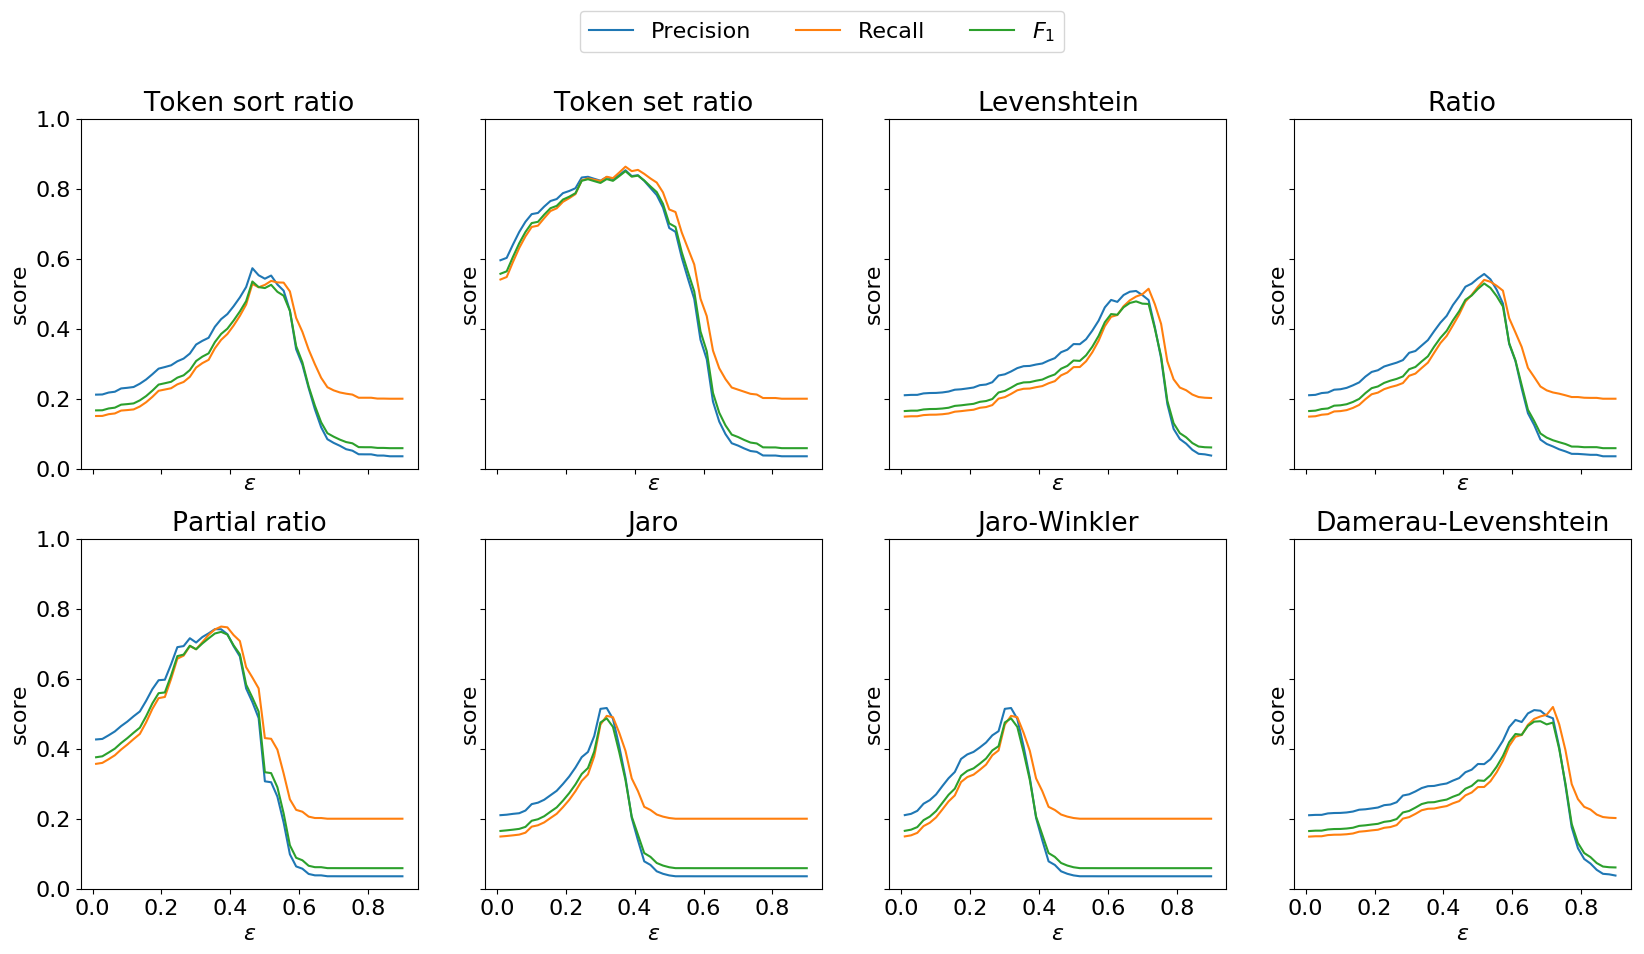

In [51]:
plt.rc('font', size=16) 
# plt.rc('axes',
#        prop_cycle=cycler('linestyle', ['-.', '--', '-']))

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20, 10))

for (distance_function_name, (precision, recall, fbeta)), axis in zip(precision_recall_fbeta.items(), axes.ravel()):
    axis.set_title(distance_function_name)
    axis.set_ylim([0, 1])   
    axis.set_xlabel(r'$\varepsilon$')
    axis.set_ylabel('score')

    l_precision, = axis.plot(eps_range, precision, markevery=10)
    l_recall, = axis.plot(eps_range, recall, markevery=2)
    l_fbeta, = axis.plot(eps_range, fbeta, markevery=2)

fig.legend((l_precision, l_recall, l_fbeta),
           labels=('Precision', 'Recall', r'$F_1$'),
           ncol=3,
           loc='upper center');

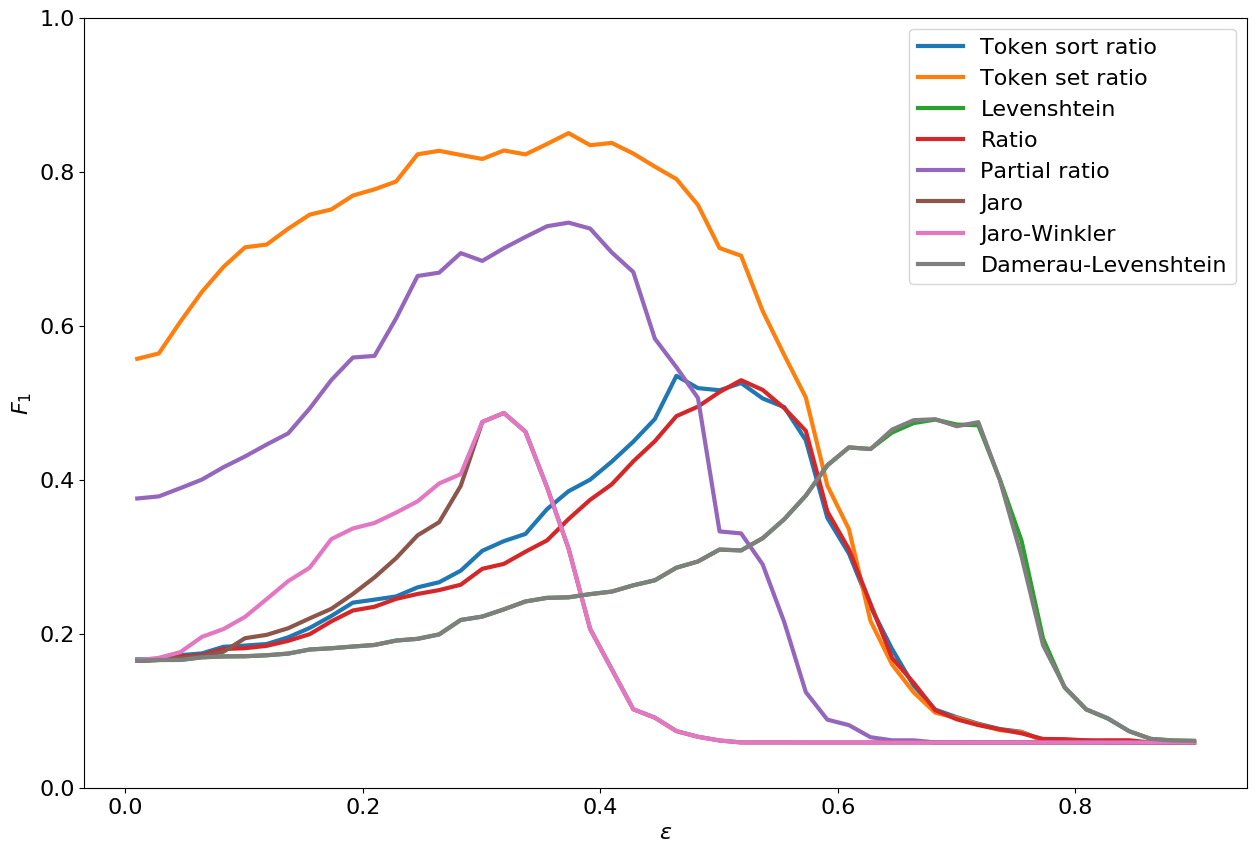

In [54]:
plt.rc('font', size=16) 

plt.figure(figsize=(15, 10))

for distance_function_name, (precision, recall, fbeta) in precision_recall_fbeta.items():
    plt.plot(eps_range, fbeta, label=distance_function_name, linewidth=3.0)

plt.ylim([0, 1])

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$F_1$')

plt.legend(loc='best', prop={'size': 16})
plt.show()

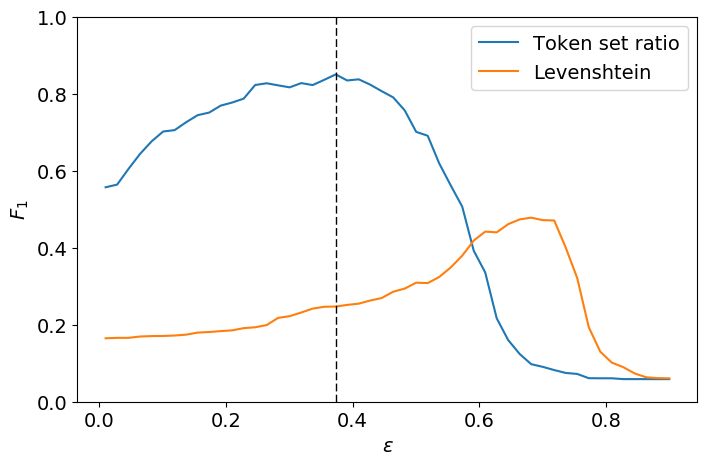

In [55]:
plt.rc('font', size=14) 
# plt.rc('lines', color='k')
# plt.rc('axes',
#        prop_cycle=cycler('marker', ['', '>']))

plt.figure(figsize=(8, 5))

# for distance_function_name, (precision, recall, fbeta) in precision_recall_fbeta.items():
f = 'Token set ratio'
plt.plot(eps_range,
         precision_recall_fbeta[f][2],
         label=f)

f = 'Levenshtein'
plt.plot(eps_range,
         precision_recall_fbeta[f][2],
         label=f)

fbeta_optimal = df.sort_values('f-beta', ascending=False)[:1]['eps']
plt.plot([fbeta_optimal, fbeta_optimal], [0, 1], 'k--', linewidth=1.0)

plt.ylim([0, 1])

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$F_1$')

plt.legend(loc='best', prop={'size': 14})
plt.show()